In [1]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import ensemble
import xgboost as xgb
from math import sqrt
import pandas as pd
import numpy as np
import warnings
import string
import copy
import ast
import math


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('train.tsv', sep = '\t')

In [3]:
train.head(5)

,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,Keywords,cast,crew
0,/7IBpOrw0ATwL1AOV97mtsceDpYs.jpg,"{'id': 556, 'name': 'Spider-Man Collection', '...",258000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",https://www.sonypictures.com/movies/spiderman3,559,tt0413300,en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The battle within.,Spider-Man 3,False,6.2,8180,"[{'id': 697, 'name': 'loss of loved one'}, {'i...","[{'cast_id': 30, 'character': 'Peter Parker / ...","[{'credit_id': '52fe4252c3a36847f80151a5', 'de..."
1,/lYeE7k0OR3HXyoq7FeswyaxFJvL.jpg,"{'id': 256296, 'name': 'Silent Night, Deadly N...",250000,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,50719,tt0093974,en,"Silent Night, Deadly Night Part 2",After being traumatized by his brother Billy's...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The nightmare is about to begin ... AGAIN!,"Silent Night, Deadly Night Part 2",False,4.3,68,"[{'id': 65, 'name': 'holiday'}, {'id': 1991, '...","[{'cast_id': 1000, 'character': 'Ricky Caldwel...","[{'credit_id': '52fe47d4c3a36847f814a70f', 'de..."
2,/gVXLIfMR2hLmkn0nACctlMCJBfx.jpg,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",https://www.scottymovie.com/,469062,tt2773246,en,Scotty and the Secret History of Hollywood,A deliciously scandalous portrait of unsung Ho...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Scotty and the Secret History of Hollywood,False,6.5,15,"[{'id': 158718, 'name': 'lgbt'}]","[{'cast_id': 1, 'character': 'Himself', 'credi...","[{'credit_id': '5980e931c3a3680cfb002d0e', 'de..."
3,/rKjE17ncAGNzeImNWbdGTimzjtk.jpg,"{'id': 8917, 'name': 'Hellraiser Collection', ...",1000000,"[{'id': 27, 'name': 'Horror'}]",NaN,9003,tt0093177,en,Hellraiser,An unfaithful wife encounters the zombie of he...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,He'll tear your soul apart.,Hellraiser,False,6.9,1115,"[{'id': 1449, 'name': 'underworld'}, {'id': 31...","[{'cast_id': 15, 'character': 'Larry Cotton', ...","[{'credit_id': '533fd9260e0a262b92001027', 'de..."
4,/zcJxJVhvxNHJJ2J7Q7NhgO9nPUV.jpg,"{'id': 108693, 'name': ""National Lampoon's Vac...",15000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 12, 'nam...",NaN,11153,tt0085995,en,National Lampoon's Vacation,Clark Griswold is on a quest to take his famil...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every summer Chevy Chase takes his family on a...,National Lampoon's Vacation,False,7.1,782,"[{'id': 5493, 'name': 'relatives'}, {'id': 731...","[{'cast_id': 1, 'character': 'Clark Griswold',...","[{'credit_id': '52fe44039251416c75025f27', 'de..."


# Data Preperation

## Data Cleansing

In [4]:
train = train.fillna(0)

In [5]:
train = train[train['revenue'] > 500] #drop all rows with missing revenue/ revenue less than 500

In [6]:
train['release_date'] = [datetime.strptime(x, '%Y-%m-%d').date() for x in train['release_date'].values]

In [7]:
train['belongs_to_collection'] = [eval(x)['name'] if x != 0 else 0 for x in train['belongs_to_collection'].values]

In [8]:
train['genres'] = [[y['name'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in train['genres'].values]

In [9]:
train['production_companies'] = [[y['name'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in train['production_companies'].values]

In [10]:
train['production_countries'] = [[y['iso_3166_1'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in train['production_countries'].values]

In [11]:
train['spoken_languages'] = [[y['iso_639_1'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in train['spoken_languages'].values]

In [12]:
train['Keywords'] = [[y['name'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in train['Keywords'].values]

In [13]:
train['cast'] = [[y['name'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in train['cast'].values]

In [14]:
train['crew'] = [[y['name'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in train['crew'].values]

In [15]:
train['release_year'] = [x.year for x in train['release_date'].values]
train['release_month'] = [x.month for x in train['release_date'].values]
train['release_day'] = [x.day for x in train['release_date'].values]
train['release_day_week'] = [x.weekday() for x in train['release_date'].values]
train['days_diff'] = [(datetime.today().date() - x).days  for x in train['release_date'].values]

## Missing Values Imputation

In [16]:
#impute budget 
train['decade'] = [math.floor(x%10000/1000)*1000 + math.floor(x%1000/100)*100 + math.floor((x)%100/10)*10 for x in train['release_year'].values]
mean_budget_decade = train[['decade','budget']].groupby('decade').mean()
mean_budget_decade = mean_budget_decade.rename(columns = {'budget':'mean_budget_decade'})
mean_budget_decade.to_pickle("mean_budget_decade.pkl")


mean_budget_year = train[['release_year','budget']].groupby('release_year').mean()
mean_budget_year = mean_budget_year.rename(columns = {'budget':'mean_budget_year'})
mean_budget_year.to_pickle("mean_budget_year.pkl")

In [17]:
train = pd.merge(train, mean_budget_decade, left_on='decade', right_on='decade') # join with decade budget

In [18]:
train = pd.merge(train, mean_budget_year, left_on='release_year', right_on='release_year') # join with decade budget

In [19]:
# ~1400 imputation
train['budget'] = [x if x != 0 else (y if y != 0 else z) for x,y,z in zip(train['budget'].values, train['mean_budget_year'].values, train['mean_budget_decade'].values)]

## Feature Engineering

### Counts Attributes

In [20]:
train['genres_count'] = [len(x) for x in train['genres'].values]

In [21]:
train['production_companies_count'] = [len(x) for x in train['production_companies'].values]

In [22]:
train['production_countries_count'] = [len(x) for x in train['production_countries'].values]

In [23]:
train['languages_count'] = [len(x) for x in train['spoken_languages'].values]

In [24]:
train['Keywords_count'] = [len(x) for x in train['Keywords'].values]

In [25]:
train['cast_count'] = [len(x) for x in train['cast'].values]

In [26]:
train['crew_count'] = [len(x) for x in train['crew'].values]

### One Hot Encoding for categorical attributes

In [27]:
def one_hot_encode(df, attribute, frac):
    total_list = []
    for y in [x for x in df[str(attribute)].values]:
        for z in y:
            total_list.append(z.lower().replace('productions','').replace('pictures',''))

    values_set = set(total_list) # get distinct values
    filtered_set =[x for x in values_set if (total_list.count(x) / len(total_list) > frac)] #get most common values
    print('distinct values for', attribute,' are:', len(filtered_set))
    for val in filtered_set:
        filterd_val = val.lower().replace('productions','').replace('pictures','')
        df[str(val)] = [1 if filterd_val in [xx.lower().replace('productions','').replace('pictures','') for xx in x] else 0 for x in df[str(attribute)].values]
    
    return df, filtered_set

In [28]:
train, genres_list = one_hot_encode(train,'genres', 0.04) #9
train, p_companies_list = one_hot_encode(train,'production_companies', 0.010) #6
train, p_countries_list = one_hot_encode(train,'production_countries', 0.05) #3
train, languages_list = one_hot_encode(train,'spoken_languages', 0.05) #3

distinct values for genres  are: 9
distinct values for production_companies  are: 6
distinct values for production_countries  are: 3
distinct values for spoken_languages  are: 3


In [29]:
import pickle
pickle.dump(genres_list, open( "genres_list.pkl", "wb" ))
pickle.dump(p_companies_list, open( "p_companies_list.pkl", "wb" ))
pickle.dump(p_countries_list, open( "p_countries_list.pkl", "wb" ))
pickle.dump(languages_list, open( "languages_list.pkl", "wb" ))

### Statistical Attributes

In [30]:
medians = train[['release_year','revenue']].groupby('release_year').median()
medians = medians.rename(columns={"revenue": "revenue_median"})
means = train[['release_year','revenue']].groupby('release_year').mean()
means = means.rename(columns={"revenue": "revenue_mean"})
total_movies = train[['release_year','id']].groupby('release_year').count()
total_movies = total_movies.rename(columns = {'id':'total_movies_year'})
collection_count = train[['belongs_to_collection','id']].groupby('belongs_to_collection').count()
collection_count = collection_count.rename(columns = {'id':'collection_size'})
collection_count = collection_count.replace(4068, 0)



medians.to_pickle("medians.pkl")
means.to_pickle("means.pkl")
total_movies.to_pickle("total_movies.pkl")
collection_count.to_pickle("collection_count.pkl")

In [31]:
train = pd.merge(train, total_movies, left_on='release_year', right_on='release_year')

In [32]:
train = pd.merge(train, medians, left_on='release_year', right_on='release_year')

In [33]:
train = pd.merge(train, means, left_on='release_year', right_on='release_year')

In [34]:
train = pd.merge(train, collection_count, left_on='belongs_to_collection', right_on='belongs_to_collection')

## External Data Sources

### Oscars

In [35]:
oscars_df = pd.read_csv('oscars_data.csv')

In [36]:
table = str.maketrans(dict.fromkeys(string.punctuation)) #to be used to convert names

In [37]:
oscars_df.head()

,year,category,winner,entity
0,1927,ACTOR,False,Richard Barthelmess
1,1927,ACTOR,True,Emil Jannings
2,1927,ACTRESS,False,Louise Dresser
3,1927,ACTRESS,True,Janet Gaynor
4,1927,ACTRESS,False,Gloria Swanson


In [38]:
all_categorys = [x for x in set(oscars_df['category'].values)]

In [39]:
good_categorys = [x for x in all_categorys if not x.startswith('SCIENTIFIC AND TECHNICAL AWARD') and not  x.startswith('SCIENTIFIC OR TECHNICAL AWARD') and not x.endswith('AWARD')]

In [40]:
oscars_df = oscars_df[oscars_df['category'].isin(good_categorys)] #take all categorys with spesific winners

In [41]:
actors_df = oscars_df[[True if x.startswith('ACT') else False for x in oscars_df['category'].values]] #take rows with actors names (not movies)

In [42]:
winning_actors_df = actors_df[actors_df['winner'] == True]
nominies_actors_df = actors_df[actors_df['winner'] == False]

In [43]:
actors_winnings = winning_actors_df[['winner','entity']].groupby('entity').count()
actors_winnings['name'] = [x.lower() for x in actors_winnings.index]
actors_winnings.to_pickle("actors_winnings.pkl")
actors_winnings_dic = {name:win for name,win in zip(actors_winnings['name'].values,actors_winnings['winner'].values)}
actors_winnings.head(5)

,winner,name
entity,,
Adrien Brody,1,adrien brody
Al Pacino,1,al pacino
Alan Arkin,1,alan arkin
Alec Guinness,1,alec guinness
Alice Brady,1,alice brady


In [44]:
actors_nominies = nominies_actors_df[['winner','entity']].groupby('entity').count()
actors_nominies['name'] = [x.lower() for x in actors_nominies.index]
actors_nominies.to_pickle("actors_nominies.pkl")
actors_nominies_dic = {name:win for name,win in zip(actors_nominies['name'].values,actors_nominies['winner'].values)}
actors_nominies.head(5)

,winner,name
entity,,
Abigail Breslin,1,abigail breslin
Adolph Caesar,1,adolph caesar
Adolphe Menjou,1,adolphe menjou
Adriana Barraza,1,adriana barraza
Agnes Moorehead,4,agnes moorehead


In [45]:
movies_df = oscars_df[[False if x.startswith('ACT') else True for x in oscars_df['category'].values]] #take rows with movie names

In [46]:
winning_movies_df = movies_df[movies_df['winner'] == True]
nominies_movies_df = movies_df[movies_df['winner'] == False]

In [47]:
movies_winnings = winning_movies_df[['winner','entity']].groupby('entity').count()
movies_winnings['name'] = [x.lower().translate(table) for x in movies_winnings.index]
movies_winnings = movies_winnings.rename(columns={"winner": "movie_oscars"})
movies_winnings.to_pickle("movies_winnings.pkl")
movies_winnings.head(5)

,movie_oscars,name
entity,,
'Round Midnight,1,round midnight
12 Years a Slave,2,12 years a slave
20 Feet from Stardom,1,20 feet from stardom
"20,000 Leagues under the Sea",2,20000 leagues under the sea
2001: A Space Odyssey,1,2001 a space odyssey


In [48]:
movies_nominies = nominies_movies_df[['winner','entity']].groupby('entity').count()
movies_nominies['name'] = [x.lower().translate(table) for x in movies_nominies.index]
movies_nominies = movies_nominies.rename(columns={"winner": "movie_nominies"})
movies_nominies.to_pickle("movies_nominies.pkl")
movies_nominies.head(5)

,movie_nominies,name
entity,,
"$1,000 a Minute",1,1000 a minute
'38',1,38
'Crocodile' Dundee,1,crocodile dundee
(A) Torzija [(A) Torsion],1,a torzija a torsion
...And Justice for All,1,and justice for all


In [49]:
def get_total_oscars(names_list, winning_dic):
    total_oscars = 0
    for x in names_list:
        x = x.lower()
        if x in winning_dic.keys():
            total_oscars += winning_dic[x]
    return total_oscars

In [50]:
#get oscars and nominees for actors in movies
train['total_actors_oscars'] = [get_total_oscars(x, actors_winnings_dic) for x in train['cast'].values]
train['total_actors_nominies'] = [get_total_oscars(x, actors_nominies_dic) for x in train['cast'].values]

In [51]:
#get oscars and nominees for movies
train['original_title'] = [x.lower().translate(table) for x in train['original_title'].values]
train = pd.merge(train, movies_winnings, left_on='original_title', right_on='name', how = 'left').fillna(0)
train = pd.merge(train, movies_nominies, left_on='original_title', right_on='name', how = 'left').fillna(0)
train = train.drop(columns = ['name_x','name_y'])

### Famous Actors & Directors

In [52]:
famous_actors_df = pd.read_csv('top_actors.csv', encoding='latin-1') #https://www.imdb.com/list/ls058011111/
famous_actors_df.to_pickle("famous_actors_df.pkl")

famous_directors_df = pd.read_csv('top_directors.csv', encoding='latin-1') #https://www.imdb.com/list/ls066140407/
famous_directors_df.to_pickle("famous_directors_df.pkl")

In [53]:
famous_actors = [x.lower() for x in famous_actors_df['Name'].values]
famous_directors = [x.lower() for x in famous_directors_df['Name'].values]

In [54]:
def get_famous(names_list, famous_list):
    total_famous = 0
    for x in names_list:
        x = x.lower()
        if x in famous_list:
            total_famous += 1000 - famous_list.index(x)
    return total_famous

In [55]:
train['famous_actors'] = [get_famous(x, famous_actors) for x in train['cast'].values] #get famous actors score
train['famous_directors'] = [get_famous(x, famous_directors) for x in train['crew'].values] #get famous directors score
train['famous_crew'] = [get_famous(x, famous_actors) for x in train['crew'].values] #get famous actors (in crew) score

# Test Data

In [56]:
test = pd.read_csv('test.tsv', sep = '\t')

In [57]:
test.head(5)

,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,Keywords,cast,crew
0,/nNh7vHHISVAaziJEqAq0P9iL52w.jpg,NaN,58000000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",http://www.lifemovie.com/,395992,tt5442430,en,Life,The six-member crew of the International Space...,...,"[{'iso_639_1': 'cn', 'name': '广州话 / 廣州話'}, {'i...",Released,Be careful what you search for,Life,False,6.4,4738,"[{'id': 839, 'name': 'planet mars'}, {'id': 48...","[{'cast_id': 0, 'character': 'Dr. David Jordan...","[{'credit_id': '58bd72b0c3a3686630048e38', 'de..."
1,/7dadBR1sXrl1TTzRQYNGUvQinF4.jpg,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,20832,tt1182908,hi,क्रैजी 4,A psychiatrist spends the majority of his time...,...,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,NaN,Krazzy 4,False,4.6,19,[],"[{'cast_id': 4, 'character': 'Raja', 'credit_i...","[{'credit_id': '5cab55c7925141565402137b', 'de..."
2,/ijDUMFmb34Fv7jBwxzhNc3lbVP3.jpg,"{'id': 410261, 'name': 'A Goofy Movie Collecti...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 16, ...",NaN,15789,tt0113198,en,A Goofy Movie,"Though Goofy always means well, his amiable cl...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It’s hard to be cool... when your dad’s Goofy.,A Goofy Movie,False,6.9,964,"[{'id': 970, 'name': 'parent child relationshi...","[{'cast_id': 2, 'character': 'Goofy Goof (voic...","[{'credit_id': '591464b9925141583c00cea9', 'de..."
3,/kb3RNnn4CMPRSaGbrX1ejc7lcRN.jpg,NaN,4000000,"[{'id': 18, 'name': 'Drama'}]",NaN,265180,tt2802154,ru,Левиафан,"In a Russian coastal town, Kolya is forced to ...",...,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Leviathan,False,7.5,447,"[{'id': 1415, 'name': 'small town'}, {'id': 19...","[{'cast_id': 3, 'character': 'Nikolay', 'credi...","[{'credit_id': '5b9c25890e0a266e12001f38', 'de..."
4,/wEo4UtBAWdB4aOmQ9wRjI1aS7Dt.jpg,NaN,250000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,10098,tt0012349,en,The Kid,A tramp cares for a boy after he's abandoned a...,...,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,6 reels of Joy.,The Kid,False,8.2,1008,"[{'id': 290, 'name': 'angel'}, {'id': 1252, 'n...","[{'cast_id': 10, 'character': 'A Tramp', 'cred...","[{'credit_id': '52fe43269251416c75005611', 'de..."


## Prepare The Data

In [58]:
def one_hot_encode_test(df, attribute, relevant_list):
    for val in relevant_list:
        filterd_val = val.lower().replace('productions','').replace('pictures','')
        df[str(val)] = [1 if filterd_val in [xx.lower().replace('productions','').replace('pictures','') for xx in x] else 0 for x in df[str(attribute)].values]
    
    return df

In [59]:
test = test.fillna(0)
# data cleansing
test['release_date'] = [datetime.strptime(x, '%Y-%m-%d').date() for x in test['release_date'].values]
test['belongs_to_collection'] = [eval(x)['name'] if x != 0 else 0 for x in test['belongs_to_collection'].values]
test['genres'] = [[y['name'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in test['genres'].values]
test['production_companies'] = [[y['name'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in test['production_companies'].values]
test['production_countries'] = [[y['iso_3166_1'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in test['production_countries'].values]
test['spoken_languages'] = [[y['iso_639_1'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in test['spoken_languages'].values]
test['Keywords'] = [[y['name'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in test['Keywords'].values]
test['cast'] = [[y['name'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in test['cast'].values]
test['crew'] = [[y['name'] for y in ast.literal_eval(x)] if x != 0 else 0 for x in test['crew'].values]
test['release_year'] = [x.year for x in test['release_date'].values]
test['release_month'] = [x.month for x in test['release_date'].values]
test['release_day'] = [x.day for x in test['release_date'].values]
test['release_day_week'] = [x.weekday() for x in test['release_date'].values]
test['days_diff'] = [(datetime.today().date() - x).days  for x in test['release_date'].values]

#missing values imputation
test['decade'] = [math.floor(x%10000/1000)*1000 + math.floor(x%1000/100)*100 + math.floor((x)%100/10)*10 for x in test['release_year'].values]
test = pd.merge(test, mean_budget_decade, left_on='decade', right_on='decade') # join with decade budget
test = pd.merge(test, mean_budget_year, left_on='release_year', right_on='release_year') # join with decade budget
test['budget'] = [x if x != 0 else (y if y != 0 else z) for x,y,z in zip(test['budget'].values, test['mean_budget_year'].values, test['mean_budget_decade'].values)]

#extra features
test['genres_count'] = [len(x) for x in test['genres'].values]
test['production_companies_count'] = [len(x) for x in test['production_companies'].values]
test['production_countries_count'] = [len(x) for x in test['production_countries'].values]
test['languages_count'] = [len(x) for x in test['spoken_languages'].values]
test['Keywords_count'] = [len(x) for x in test['Keywords'].values]
test['cast_count'] = [len(x) for x in test['cast'].values]
test['crew_count'] = [len(x) for x in test['crew'].values]

#one hot incode
test = one_hot_encode_test(test,'genres', genres_list)
test = one_hot_encode_test(test,'production_companies', p_companies_list) 
test = one_hot_encode_test(test,'production_countries', p_countries_list) 
test = one_hot_encode_test(test,'spoken_languages', languages_list) 

#statistical features
test = pd.merge(test, total_movies, left_on='release_year', right_on='release_year')
test = pd.merge(test, medians, left_on='release_year', right_on='release_year')
test = pd.merge(test, means, left_on='release_year', right_on='release_year')
test = pd.merge(test, collection_count, left_on='belongs_to_collection', right_on='belongs_to_collection')

#external data sources
test['total_actors_oscars'] = [get_total_oscars(x, actors_winnings_dic) for x in test['cast'].values]
test['total_actors_nominies'] = [get_total_oscars(x, actors_nominies_dic) for x in test['cast'].values]
test['original_title'] = [x.lower().translate(table) for x in test['original_title'].values]
test = pd.merge(test, movies_winnings, left_on='original_title', right_on='name', how = 'left').fillna(0)
test = pd.merge(test, movies_nominies, left_on='original_title', right_on='name', how = 'left').fillna(0)
test = test.drop(columns = ['name_x','name_y'])
test['famous_actors'] = [get_famous(x, famous_actors) for x in test['cast'].values] #get famous actors score
test['famous_directors'] = [get_famous(x, famous_directors) for x in test['crew'].values] #get famous directors score
test['famous_crew'] = [get_famous(x, famous_actors) for x in test['crew'].values] #get famous actors (in crew) score

# Model Selection and Evaluation

In [108]:
bad_columns = ['backdrop_path', 'belongs_to_collection','genres','homepage','id','imdb_id','original_title','poster_path','production_companies',
               'production_countries','spoken_languages','status','tagline','video','Keywords','cast','crew','overview','release_date','title','original_language',
               ]

my_train = train[[x for x in train.columns if x not in bad_columns]]          
X_train = my_train[[x for x in my_train.columns if x != 'revenue']]
Y_train = my_train[[ 'revenue']]

my_test = test[[x for x in test.columns if x not in bad_columns]]
X_test = my_test[[x for x in my_test.columns if x != 'revenue']]
Y_test = my_test[[ 'revenue']]

# my_train.to_csv('data_for_learning.csv', index=False)
# my_test.to_csv('data_for_testing.csv', index=False)

## GBT

In [ ]:
%%time
import time
best_score = 100000
best_params = [0,0,0,0]
for max_d in [10, 30]:
    for min_smpls in [2, 5]:
        for l_r in [0.03, 0.05]:
            for n_es in [500, 750]:
                start = time.time()
                print('------------------------------------------')
                print(max_d, min_smpls, l_r, n_es)
                params = {'n_estimators': n_es, 'max_depth': max_d, 'min_samples_split': min_smpls,'learning_rate': l_r, 'loss': 'ls'}
                clf = ensemble.GradientBoostingRegressor(**params)
                clf.fit(X_train, Y_train)
                temp_score = np.sqrt(mean_squared_log_error(Y_test, [x * -1 if x < 0 else x for x in clf.predict(X_test)]))
                print('time took:', time.time() - start,' score is:', temp_score)
                if temp_score < best_score:
                    best_score = temp_score
                    best_params = [max_d, min_smpls, l_r, n_es]
                    

## XGBoost

In [158]:
best_score = 2.2733892852668953
best_params = [0,0,0,0]
for max_d in [7, 10, 12]:
    for cols_by in [0.9]:
        for l_r in [0.01, 0.05, 0.03, 0.1]:
            for n_es in [400, 750, 1000]:
                for alp in [100, 50, 10, 1000]:
                    start = time.time()
                    clf = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = cols_by, learning_rate = l_r,
                    max_depth = max_d, alpha = alp, n_estimators = n_es)
                    clf.fit(X_train, Y_train)
                    temp_score = np.sqrt(mean_squared_log_error(Y_test, [200000 if x < 0 else x for x in clf.predict(X_test)]))
                    if temp_score < best_score:
                        print('------------------------------------------')
                        print(max_d, cols_by, l_r, n_es, alp)
                        print('time took:', time.time() - start,' score is:', temp_score)
                        best_score = temp_score
                        best_params = [max_d, cols_by, l_r, n_es, alp]

In [141]:
best_score

2.2733892852668953

In [142]:
best_params

[7, 0.9, 0.03, 750, 10]

## Results Analysis

In [143]:
# Best classifier
clf = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.03,
max_depth = 7, alpha = 10, n_estimators = 750)
clf.fit(X_train, Y_train)
print('RMSLE:',np.sqrt(mean_squared_log_error(Y_test, [200000 if x < 0 else x for x in clf.predict(X_test)])))
print('RMSE:',sqrt(mean_squared_error(Y_test, [200000 if x < 0 else x for x in clf.predict(X_test)])))

RMSLE: 2.2733892852668953
RMSE: 79217998.79446784


In [157]:
pickle.dump(clf, open( "xgboost_clf.pkl", "wb" ))

In [92]:
xgboost_clf = pickle.load(open("xgboost_clf.pkl", "rb"))
print('RMSLE:',np.sqrt(mean_squared_log_error(Y_test, [200000 if x < 0 else x for x in xgboost_clf.predict(X_test)])))
print('RMSE:',sqrt(mean_squared_error(Y_test, [200000 if x < 0 else x for x in xgboost_clf.predict(X_test)])))

RMSLE: 2.285963566047724
RMSE: 80463960.56013104


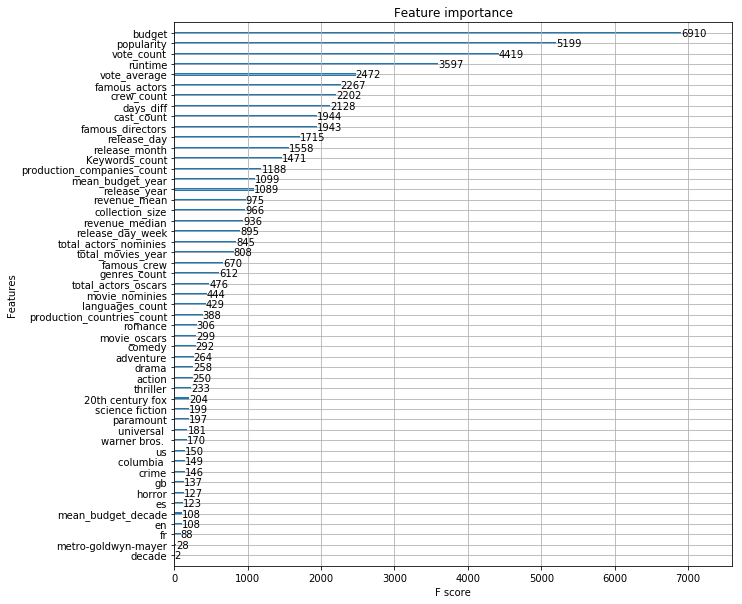

In [144]:
xgb.plot_importance(clf)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [145]:
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.9,'learning_rate': 0.03,
                'max_depth': 7, 'alpha': 10, 'n_estimators' : 750}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=100,early_stopping_rounds=10, metrics="rmsle", as_pandas=True, seed=123)


In [146]:
cv_results.head()

,train-rmsle-mean,train-rmsle-std,test-rmsle-mean,test-rmsle-std
0,3.198276,0.004971,3.234025,0.053842
1,2.650075,0.008622,2.677439,0.069747
2,2.391095,0.011049,2.420374,0.076832
3,2.232705,0.010124,2.264249,0.074130
4,2.128826,0.009782,2.162339,0.072941


In [147]:
print((cv_results["test-rmsle-mean"]).tail(1))

14    1.927208
Name: test-rmsle-mean, dtype: float64


In [148]:
import copy
my_test['prediction_rev'] = clf.predict(X_test)
ploting_test = copy.copy(my_test)
ploting_test['prediction_rev'] = [x / 1000000 for x in ploting_test['prediction_rev'].values]
ploting_test['revenue'] = [x / 1000000 for x in ploting_test['revenue'].values]

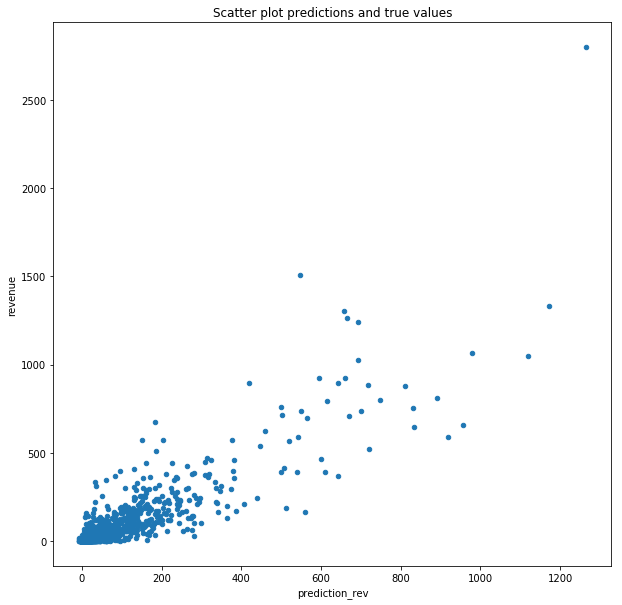

In [156]:
ploting_test.plot.scatter(x='prediction_rev', y='revenue', title= "Scatter plot predictions and true values")

In [150]:
preds_and_true = my_test[['revenue','prediction_rev','release_year']]

In [151]:
preds_and_true['diff'] = [x - y for x,y in zip(preds_and_true['revenue'].values, preds_and_true['prediction_rev'].values )]

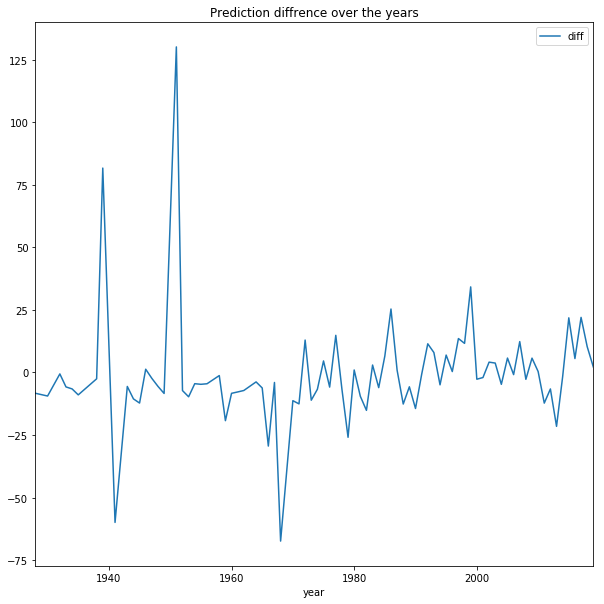

In [152]:
helper = preds_and_true[['release_year','diff']].groupby('release_year').mean()
helper['diff'] = [x / 1000000 for x in helper['diff'].values]
helper['year'] = helper.index
plt.rcParams['figure.figsize'] = [10, 10]
# plt.title('Prediction diffrence over the years')
helper.plot(kind='line',x= 'year' ,y ='diff',title = 'Prediction diffrence over the years')


In [153]:
helpper =  my_test[['revenue','prediction_rev','release_year']].groupby('release_year').mean()
helpper['year'] = helpper.index
helpper['revenue'] = [x / 1000000 for x in helpper['revenue'].values]
helpper['prediction_rev'] = [x / 1000000 for x in helpper['prediction_rev'].values]


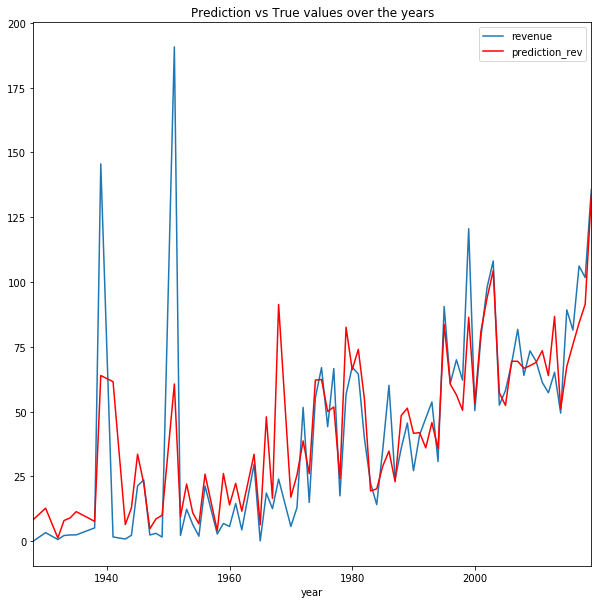

In [154]:
ax = plt.gca()
helpper.plot(kind='line',x= 'year' ,y ='revenue',title = 'Prediction vs True values over the years', ax = ax)
helpper.plot(kind='line',x= 'year' ,y ='prediction_rev', color = 'red', ax = ax)
plt.show()

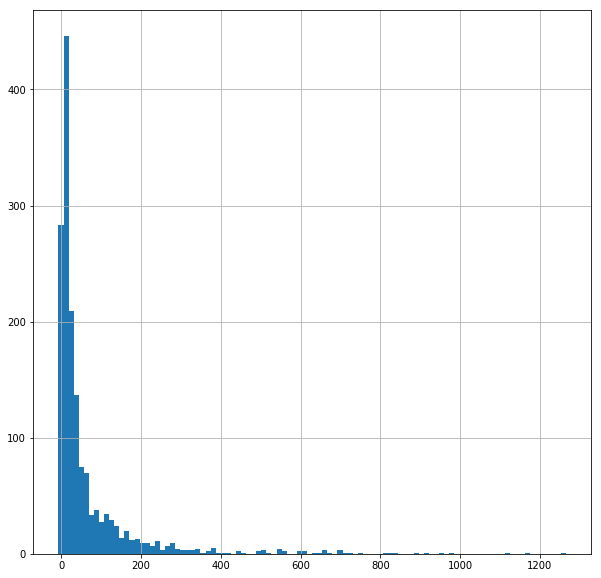

In [155]:
ploting_test['prediction_rev'].hist(bins = 100)